# 1. Imports

In [26]:
import pandas as pd
import numpy as np
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display    import HTML
from IPython.display         import Image
from statsmodels.stats       import api as sms

## 1.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20,8]
    plt.rcParams['font.size'] = 11

    display( HTML( '<style>.container { width:80% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option( 'display.max_columns', None )

    sns.set_style("darkgrid")
    sns.set_palette("muted")

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 1.2. Load Dataset

In [4]:
df1 = pd.read_csv('../data/ab_testing.csv')

In [5]:
df1.head()

,uid,country,gender,spent,purchases,date,group,device
0,11115722,MEX,F,1595,5,2016-03-08,GRP B,I
1,11122053,USA,M,498,2,2017-07-14,GRP B,I
2,11128688,USA,F,2394,6,2017-09-17,GRP A,I
3,11130578,USA,F,1197,3,2017-11-30,GRP A,I
4,11130759,ESP,M,1297,3,2018-01-10,GRP B,A


# 2. Data Description

In [6]:
df2 = df1.copy()

## 2.1. Data Dimensions

In [7]:
print('Number of rows: {0}'.format(df2.shape[0]))
print('Number of columns: {0}'.format(df2.shape[1]))

Number of rows: 45883
Number of columns: 8


## 2.2. Data Types

In [8]:
df2.dtypes

uid           int64
country      object
gender       object
spent         int64
purchases     int64
date         object
group        object
device       object
dtype: object

## 2.3.  Check NA

In [9]:
df2.isna().sum()

uid          0
country      0
gender       0
spent        0
purchases    0
date         0
group        0
device       0
dtype: int64

## 2.4.  Check Duplicate Users

In [21]:
# Number of duplicated users
df2[['uid', 'group']].groupby( 'uid' ).count().reset_index().query( 'group > 1' )

,uid,group


## 2.5. Change dtypes

In [10]:
df2['date'] = pd.to_datetime( df2['date'], yearfirst=True )

In [11]:
df2.dtypes

uid                   int64
country              object
gender               object
spent                 int64
purchases             int64
date         datetime64[ns]
group                object
device               object
dtype: object

In [12]:
df2.isna().sum()

uid          0
country      0
gender       0
spent        0
purchases    0
date         0
group        0
device       0
dtype: int64

## 2.6. Descriptive Statistics

In [13]:
num_attributes = df2.select_dtypes(include=["int64"])
cat_attributes = df2.select_dtypes(exclude=["int64", "datetime64[ns]"])

### 2.6.1. Numerical Attributes

In [14]:
# central tendency
_mean   = pd.DataFrame( num_attributes.apply( np.mean ) ).T
_median = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion
_std   = pd.DataFrame( num_attributes.apply( np.std ) ).T
_min   = pd.DataFrame( num_attributes.apply( np.min ) ).T
_max   = pd.DataFrame( num_attributes.apply( np.max ) ).T
_range = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
_skew  = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
_kurtosis  = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
summary = pd.concat( [_min, _max, _range, _mean, _median, _std, _skew, _kurtosis] ).T.reset_index()
summary.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
summary

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,uid,11115722.0,99999383.0,88883661.0,5.544232e+07,55312026.0,2.558651e+07,0.007913,-1.190403
1,spent,99.0,12170.0,12071.0,1.883453e+03,1596.0,1.363907e+03,1.365817,2.627362
2,purchases,1.0,30.0,29.0,4.544385e+00,4.0,3.102420e+00,1.348301,2.562334


### 2.6.2.  Categorical Attributes

In [15]:
# Qtd. of unique attributes per feature
cat_attributes.apply(lambda x: x.unique().shape[0])

country    10
gender      2
group       2
device      2
dtype: int64

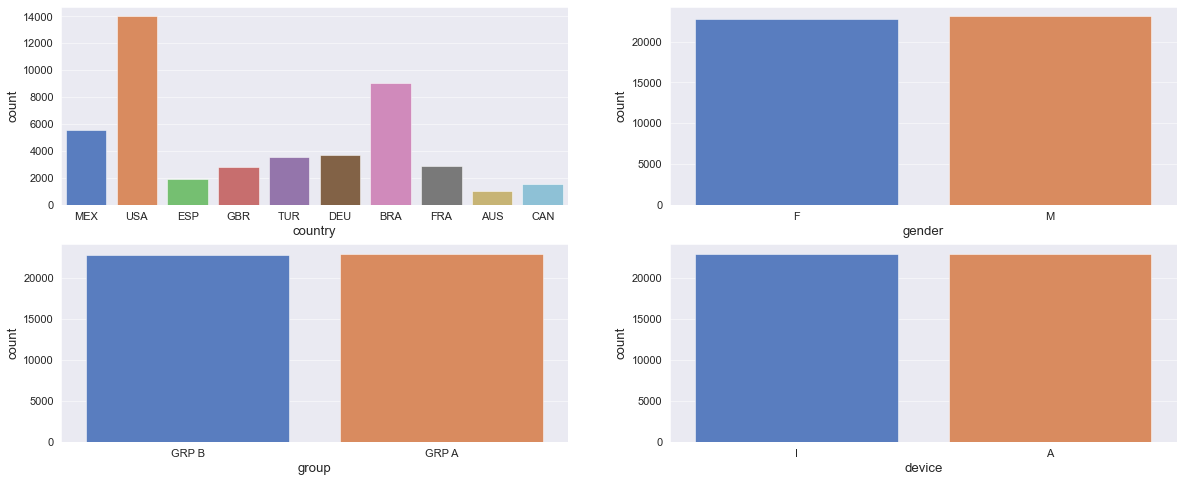

In [16]:
fig, axes = plt.subplots(2,2)

sns.countplot( x='country', data=cat_attributes, ax=axes[0,0] )
sns.countplot( x='gender' , data=cat_attributes, ax=axes[0,1] )
sns.countplot( x='group'  , data=cat_attributes, ax=axes[1,0] )
sns.countplot( x='device' , data=cat_attributes, ax=axes[1,1] );

* The dataset is well balanced for group, device and gender.

# 3. EDA

In [17]:
df3 = df2.copy()

## 3.1. Univariate Analysis

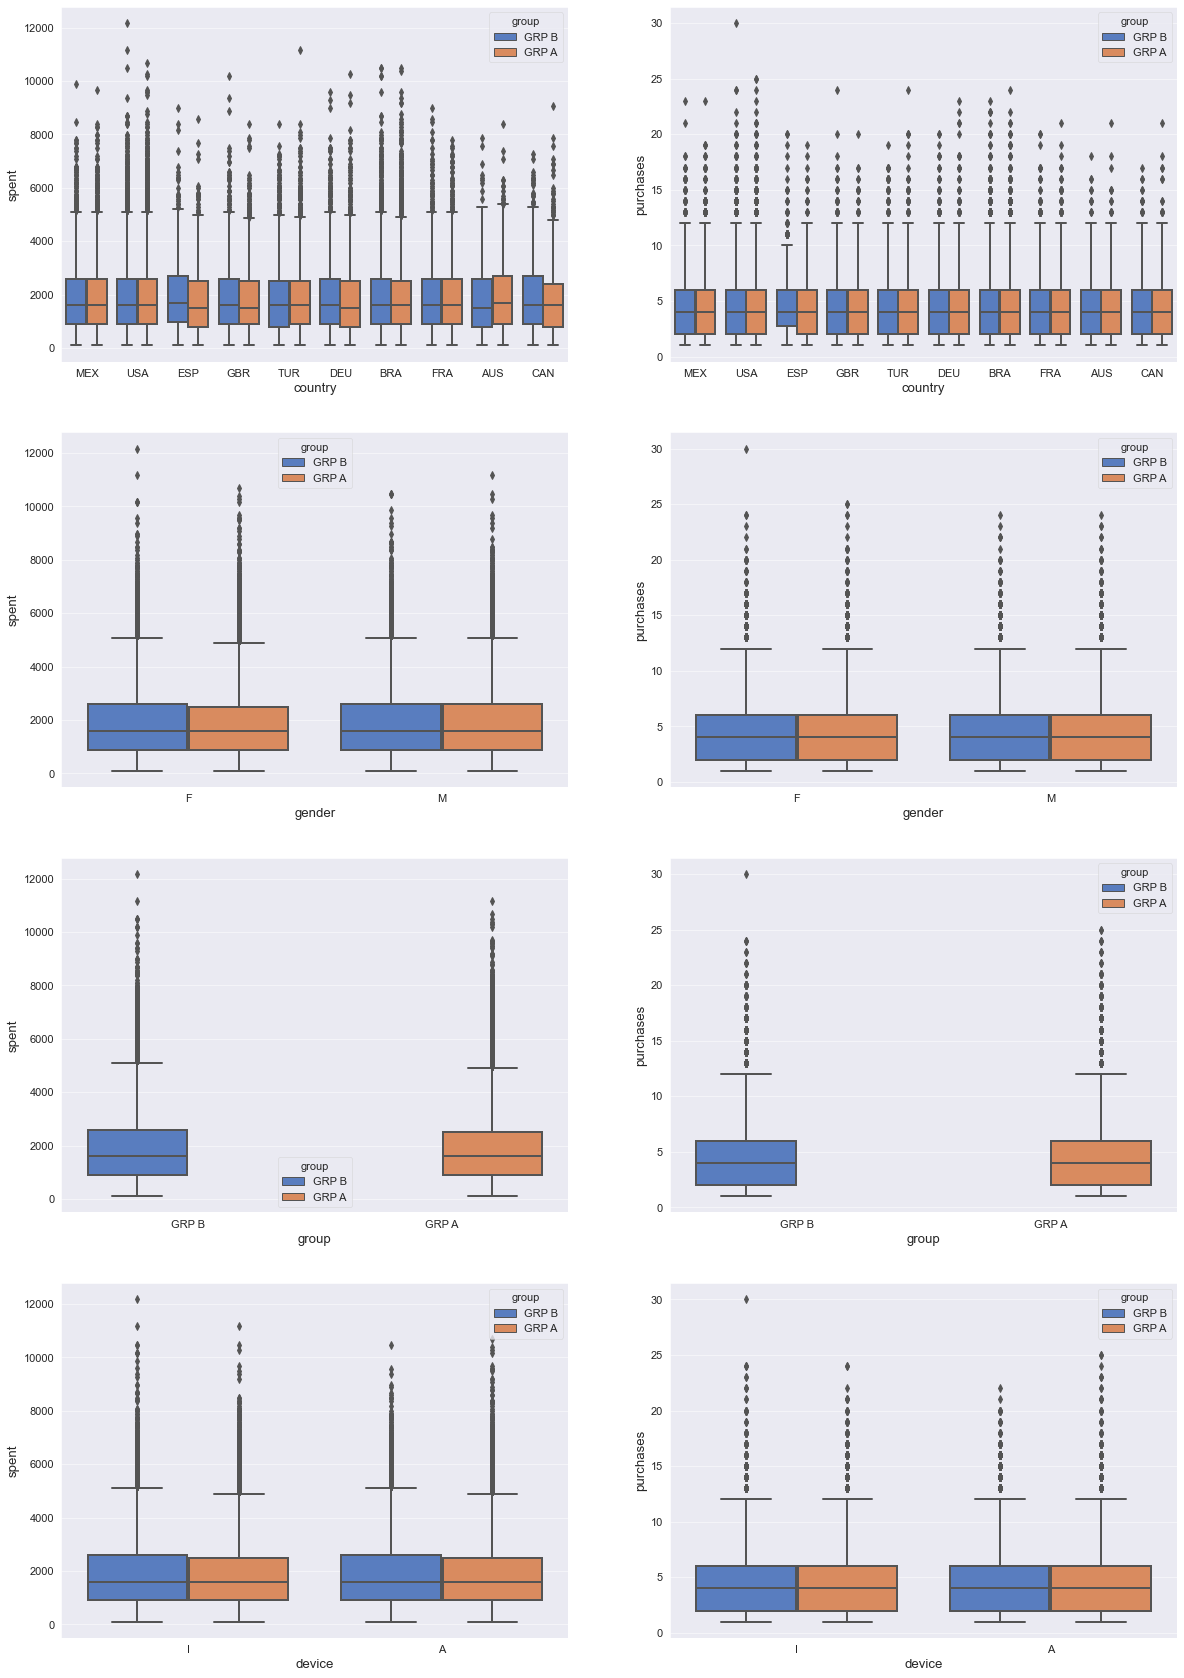

In [18]:
fig, axes = plt.subplots(4,2, figsize=(20,30))


for i, col in enumerate(cat_attributes):
    sns.boxplot(x=col,  y='spent'    , hue='group', data=df3, ax=axes[i,0] )
    sns.boxplot(x=col,  y='purchases', hue='group', data=df3, ax=axes[i,1] )

* The differences in distribution considering the groups A and B are minimum for the different categorical attributes.
* It was not possible to indetify some behavior.

# 4. A/B Test

In [27]:
df4 = df3.copy()

## 4.1. Split Groups

In [29]:
df_treatment = df4[df4['group'] == "GRP A"]
df_control = df4[df4['group'] == "GRP B"]

In [38]:
print("Number of samples for treatment: {0}".format(df_treatment.shape[0]))
print("Number of samples for control: {0}".format(df_control.shape[0]))

Number of samples for treatment: 23009
Number of samples for control: 22874


## 4.2. Experiment Parameters

In [74]:
# confidence level
conf_level = 0.95

# significance level
sig_level = 1 - conf_level

# effect size
p1 = df_treatment["purchases"].tolist()
p2 = df_control["purchases"].tolist()

eff_size = pg.compute_effsize(p2, p1, eftype='cohen')

# Statistical power
power = 0.8

In [75]:
# sample size



sample_n = sms.NormalIndPower().solve_power(
    effect_size=eff_size,
    power=power,
    alpha=sig_level
)

sample_n = math.ceil( sample_n )
print( 'The sample size for the control and tratment group is {}.'.format(sample_n) )
print( 'The total sample size is {}.'.format(2*sample_n) )

The sample size for the control and tratment group is 582479.
The total sample size is 1164958.


* We don't have enough samples to continue the experiment, even with a lower power or confidence level.